In [1]:
# Orignial Notebook: https://github.com/MITESHPUTHRANNEU/Speech-Emotion-Analyzer/blob/master/final_results_gender_test.ipynb
# This notebook author: Reza Chu
# Last Editing Date: 31st May 2019

## Python
import os
import random
import sys


## Package
import glob 
import keras
import IPython.display as ipd
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.graph_objs as go
import plotly.offline as py
import plotly.tools as tls
import seaborn as sns
import scipy.io.wavfile
import tensorflow as tf
py.init_notebook_mode(connected=True)


## Keras
from keras import regularizers
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping
from keras.callbacks import  History, ReduceLROnPlateau, CSVLogger
from keras.models import Model, Sequential
from keras.layers import Dense, Embedding, LSTM
from keras.layers import Input, Flatten, Dropout, Activation, BatchNormalization
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.preprocessing import sequence
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.utils import np_utils
from keras.utils import to_categorical


## Sklearn
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder


## Rest
from scipy.fftpack import fft
from scipy import signal
from scipy.io import wavfile
from tqdm import tqdm

input_duration=3

C:\Users\Subham\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
# Data Directory
# Please edit according to your directory change.
dir_list = os.listdir('../AudioWAV/')
dir_list.sort()

### Sentences:

It's eleven o'clock (IEO). <br>
That is exactly what happened (TIE). <br>
I'm on my way to the meeting (IOM). <br>
I wonder what this is about (IWW). <br>
The airplane is almost full (TAI). <br>
Maybe tomorrow it will be cold (MTI). <br>
I would like a new alarm clock (IWL) <br>
I think I have a doctor's appointment (ITH). <br>
Don't forget a jacket (DFA). <br>
I think I've seen this before (ITS). <br>
The surface is slick (TSI). <br>
We'll stop in a couple of minutes (WSI). <br>

### Emotions:

Anger (ANG) <br>
Disgust (DIS) <br>
Fear (FEA) <br>
Happy/Joy (HAP) <br>
Neutral (NEU) <br>
Sad (SAD) <br>

### Level
Low (LO) <br>
Medium (MD) <br>
High (HI) <br>
Unspecified (XX) <br>

In [8]:
dir_list[0]

'1001_DFA_ANG_XX.wav'

In [20]:
# Create DataFrame for Data intel
df = pd.DataFrame(columns=['path', 'actor', 'gender','intensity', 'statement', 'emotion'])

count = 0

for i in dir_list:
    nm = i.split("_")
    path = '../AudioWAV/' + i
    actor = nm[0]
    statement = nm[1]
    emotion = nm[2]
    intensity = nm[3].split(".")[0]
    if int(actor) >= 1049:
        gender = "female"
    else:
        gender = "male"
            
    df.loc[count] = [path, actor, gender, intensity, statement, emotion]
    count += 1

In [21]:
df.head()

,path,actor,gender,intensity,statement,emotion
0,../AudioWAV/1001_DFA_ANG_XX.wav,1001,male,XX,DFA,ANG
1,../AudioWAV/1001_DFA_DIS_XX.wav,1001,male,XX,DFA,DIS
2,../AudioWAV/1001_DFA_FEA_XX.wav,1001,male,XX,DFA,FEA
3,../AudioWAV/1001_DFA_HAP_XX.wav,1001,male,XX,DFA,HAP
4,../AudioWAV/1001_DFA_NEU_XX.wav,1001,male,XX,DFA,NEU


In [22]:
len(df)

7442

In [23]:
filename = df.path[1021]
print (filename)

samples, sample_rate = librosa.load(filename)
sample_rate, samples

../AudioWAV/1013_IWW_NEU_XX.wav


(22050, array([ 2.6419104e-04,  3.5802430e-05, -2.7152000e-04, ...,
         1.5600528e-04,  1.2293330e-04,  0.0000000e+00], dtype=float32))

In [24]:
len(samples), sample_rate

(58123, 22050)

In [25]:
def log_specgram(audio, sample_rate, window_size=20,
                 step_size=10, eps=1e-10):
    nperseg = int(round(window_size * sample_rate / 1e3))
    noverlap = int(round(step_size * sample_rate / 1e3))
    freqs, times, spec = signal.spectrogram(audio,
                                    fs=sample_rate,
                                    window='hann',
                                    nperseg=nperseg,
                                    noverlap=noverlap,
                                    detrend=False)
    return freqs, times, np.log(spec.T.astype(np.float32) + eps)

In [26]:
sample_rate/ len(samples)

0.3793678922285498

Text(0.5,0,'Seconds')

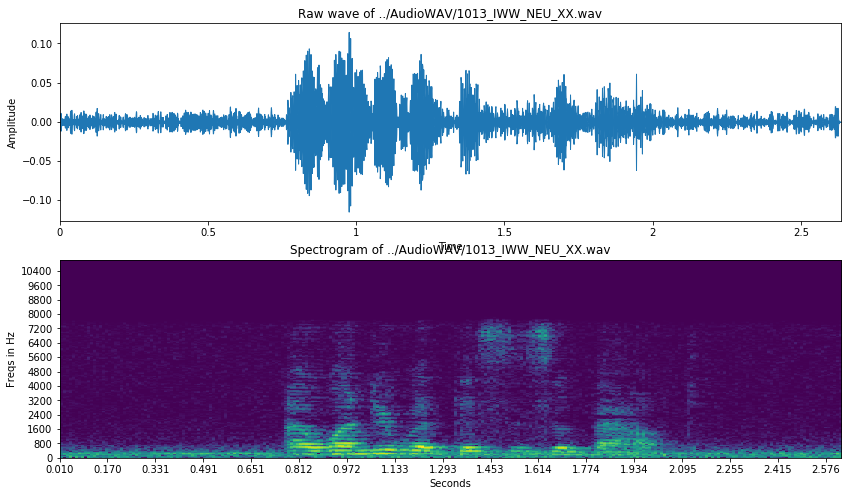

In [30]:
# Plotting Wave Form and Spectrogram
freqs, times, spectrogram = log_specgram(samples, sample_rate)

fig = plt.figure(figsize=(14, 8))
ax1 = fig.add_subplot(211)
ax1.set_title('Raw wave of ' + filename)
ax1.set_ylabel('Amplitude')
librosa.display.waveplot(samples, sr=sample_rate)

ax2 = fig.add_subplot(212)
ax2.imshow(spectrogram.T, aspect='auto', origin='lower', 
           extent=[times.min(), times.max(), freqs.min(), freqs.max()])
ax2.set_yticks(freqs[::16])
ax2.set_xticks(times[::16])
ax2.set_title('Spectrogram of ' + filename)
ax2.set_ylabel('Freqs in Hz')
ax2.set_xlabel('Seconds')

In [31]:
mean = np.mean(spectrogram, axis=0)
std = np.std(spectrogram, axis=0)
spectrogram = (spectrogram - mean) / std

In [56]:
# Trim the silence voice
aa , bb = librosa.effects.trim(samples, top_db=13)
aa, bb

(array([-0.00238423, -0.00169365, -0.00099868, ..., -0.01242722,
        -0.01117711, -0.01110893], dtype=float32), array([16896, 44544]))

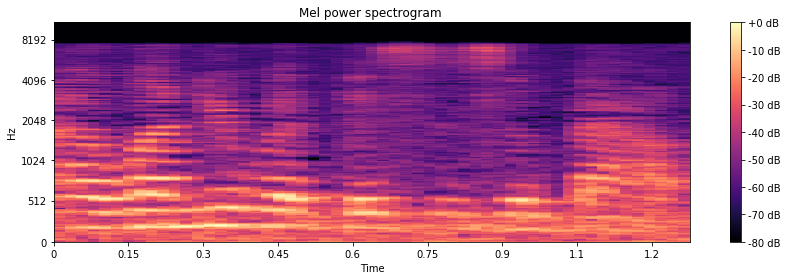

In [60]:
# Plotting Mel Power Spectrogram
S = librosa.feature.melspectrogram(aa, sr=sample_rate, n_mels=256)

# Convert to log scale (dB). We'll use the peak power (max) as reference.
log_S = librosa.power_to_db(S, ref=np.max)

plt.figure(figsize=(12, 4))
librosa.display.specshow(log_S, sr=sample_rate, x_axis='time', y_axis='mel')
plt.title('Mel power spectrogram ')
plt.colorbar(format='%+02.0f dB')
plt.tight_layout()

C:\Users\Subham\Anaconda3\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



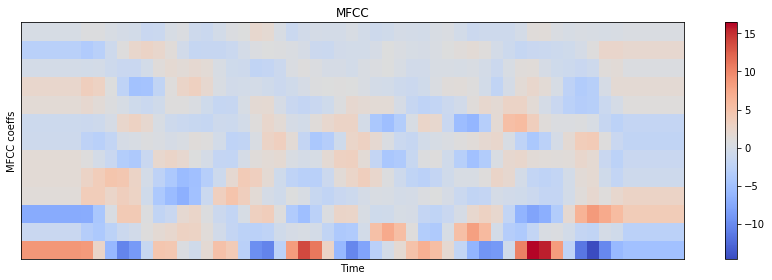

In [61]:
# Plotting MFCC
mfcc = librosa.feature.mfcc(S=log_S, n_mfcc=13)

# Let's pad on the first and second deltas while we're at it
delta2_mfcc = librosa.feature.delta(mfcc, order=2)

plt.figure(figsize=(12, 4))
librosa.display.specshow(delta2_mfcc)
plt.ylabel('MFCC coeffs')
plt.xlabel('Time')
plt.title('MFCC')
plt.colorbar()
plt.tight_layout()

In [62]:
# Original Sound
ipd.Audio(samples, rate=sample_rate)

In [63]:
# Silence trimmed Sound by librosa.effects.trim()
ipd.Audio(aa, rate=sample_rate)

In [64]:
# Silence trimmed Sound by manuel trimming
samples_cut = samples[10000:-12500]
ipd.Audio(samples_cut, rate=sample_rate)

# Define Labels

### Emotions:

Anger (ANG) <br>
Disgust (DIS) <br>
Fear (FEA) <br>
Happy/Joy (HAP) <br>
Neutral (NEU) <br>
Sad (SAD) <br>

### Level
Low (LO) <br>
Medium (MD) <br>
High (HI) <br>
Unspecified (XX) <br>

In [65]:
# 2 class: Positive & Negative

# Positive: Calm, Happy
# Negative: Angry, Fearful, Sad

label2_list = []
for i in range(len(df)):
    if df.emotion[i] == 'NEU': # Neutral
        lb = "_positive"
    elif df.emotion[i] == 'HAP': # Happy
        lb = "_positive"
    elif df.emotion[i] == 'SAD': # Sad
        lb = "_negative"
    elif df.emotion[i] == 'ANG': # Angry
        lb = "_negative"
    elif df.emotion[i] == 'FEA': # Fearful
        lb = "_negative"
    elif df.emotion[i] == 'DIS': # Fearful
        lb = "_negative"
    else:
        lb = "_none"
        
    # Add gender to the label    
    label2_list.append(df.gender[i] + lb)
    
len(label2_list)

7442

In [66]:
# 2 class: Positive & Negative

# Positive: Calm, Happy
# Negative: Angry, Fearful, Sad

label3_list = []
for i in range(len(df)):
    if df.emotion[i] == 'NEU': # Neutral
        lb = "_neutral"
    elif df.emotion[i] == 'HAP': # Happy
        lb = "_positive"
    elif df.emotion[i] == 'SAD': # Sad
        lb = "_negative"
    elif df.emotion[i] == 'ANG': # Angry
        lb = "_negative"
    elif df.emotion[i] == 'FEA': # Fearful
        lb = "_negative"
    elif df.emotion[i] == 'DIS': # Fearful
        lb = "_negative"
    else:
        lb = "_none"
        
    # Add gender to the label    
    label3_list.append(df.gender[i] + lb)
    
len(label3_list)

7442

In [67]:
# 6 class: angry, neutral, sad, happy, fearful & disgust
label5_list = []
for i in range(len(df)):
    if df.emotion[i] == 'NEU':
        lb = "_neutral"
    elif df.emotion[i] == 'HAP':
        lb = "_happy"
    elif df.emotion[i] == 'SAD':
        lb = "_sad"
    elif df.emotion[i] == 'ANG':
        lb = "_angry"
    elif df.emotion[i] == 'FEA':
        lb = "_fearful"    
    elif df.emotion[i] == 'DIS':
        lb = "_disgust"   
    else:
        lb = "_none"
    
    # Add gender to the label  
    label5_list.append(df.gender[i] + lb)
    
len(label5_list)

7442

In [88]:
# Select the label set you want by commenting the unwanteds.

df['label'] = label2_list
# data_df['label'] = label3_list
# data_df['label'] = label5_list
# data_df['label'] = label8_list
df.head()

,path,actor,gender,intensity,statement,emotion,label
0,../AudioWAV/1001_DFA_ANG_XX.wav,1001,male,XX,DFA,ANG,male_negative
1,../AudioWAV/1001_DFA_DIS_XX.wav,1001,male,XX,DFA,DIS,male_negative
2,../AudioWAV/1001_DFA_FEA_XX.wav,1001,male,XX,DFA,FEA,male_negative
3,../AudioWAV/1001_DFA_HAP_XX.wav,1001,male,XX,DFA,HAP,male_positive
4,../AudioWAV/1001_DFA_NEU_XX.wav,1001,male,XX,DFA,NEU,male_positive


In [89]:
print (df.label.value_counts())

male_negative      2676
female_negative    2408
male_positive      1241
female_positive    1117
Name: label, dtype: int64


In [90]:
# Plotting the emotion distribution

def plot_emotion_dist(dist, color_code='#C2185B', title="Plot"):
    """
    To plot the data distributioin by class.
    Arg:
      dist: pandas series of label count. 
    """
    tmp_df = pd.DataFrame()
    tmp_df['Emotion'] = list(dist.keys())
    tmp_df['Count'] = list(dist)
    fig, ax = plt.subplots(figsize=(14, 7))
    ax = sns.barplot(x="Emotion", y='Count', color=color_code, data=tmp_df)
    ax.set_title(title)
    ax.set_xticklabels(ax.get_xticklabels(),rotation=45)

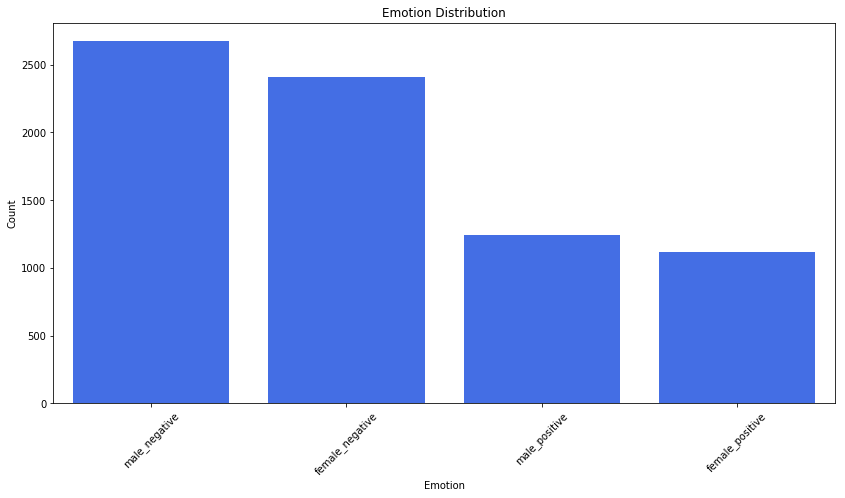

In [91]:
a = df.label.value_counts()
plot_emotion_dist(a, "#2962FF", "Emotion Distribution")

# Data Splitting

In [86]:
# Female Data Set

## Uncomment all below to use Female set 

# data2_df = data_df.copy()
# data2_df = data2_df[data2_df.label != "male_none"]
# data2_df = data2_df[data2_df.label != "female_none"]
# data2_df = data2_df[data2_df.label != "male_happy"]
# data2_df = data2_df[data2_df.label != "male_angry"]
# data2_df = data2_df[data2_df.label != "male_sad"]
# data2_df = data2_df[data2_df.label != "male_fearful"]
# data2_df = data2_df[data2_df.label != "male_calm"]
# data2_df = data2_df[data2_df.label != "male_positive"]
# data2_df = data2_df[data2_df.label != "male_negative"].reset_index(drop=True)

# tmp1 = data2_df[data2_df.actor == 22]
# tmp2 = data2_df[data2_df.actor == 24]
# data3_df = pd.concat([tmp1, tmp2],ignore_index=True).reset_index(drop=True)
# data2_df = data2_df[data2_df.actor != 22]
# data2_df = data2_df[data2_df.actor != 24].reset_index(drop=True)
# print (len(data2_df))
# data2_df.head()

In [87]:
print (df.label.value_counts())

male_disgust      669
male_happy        669
male_angry        669
male_fearful      669
male_sad          669
female_sad        602
female_angry      602
female_disgust    602
female_fearful    602
female_happy      602
male_neutral      572
female_neutral    515
Name: label, dtype: int64


In [92]:
# Male Data Set

## Uncomment all below to use Male set 

data2_df = df.copy()
data2_df = data2_df[data2_df.label != "female_happy"]
data2_df = data2_df[data2_df.label != "female_neutral"]
data2_df = data2_df[data2_df.label != "female_angry"]
data2_df = data2_df[data2_df.label != "female_sad"]
data2_df = data2_df[data2_df.label != "female_fearful"]
data2_df = data2_df[data2_df.label != "female_positive"]
data2_df = data2_df[data2_df.label != "female_negative"].reset_index(drop=True)

tmp1 = data2_df[data2_df.actor == 21]
tmp2 = data2_df[data2_df.actor == 22]
tmp3 = data2_df[data2_df.actor == 23]
tmp4 = data2_df[data2_df.actor == 24]
data3_df = pd.concat([tmp1, tmp3],ignore_index=True).reset_index(drop=True)
data2_df = data2_df[data2_df.actor != 21]
data2_df = data2_df[data2_df.actor != 22]
data2_df = data2_df[data2_df.actor != 23].reset_index(drop=True)
data2_df = data2_df[data2_df.actor != 24].reset_index(drop=True)
print (len(data2_df))
data2_df.head()

3917


,path,actor,gender,intensity,statement,emotion,label
0,../AudioWAV/1001_DFA_ANG_XX.wav,1001,male,XX,DFA,ANG,male_negative
1,../AudioWAV/1001_DFA_DIS_XX.wav,1001,male,XX,DFA,DIS,male_negative
2,../AudioWAV/1001_DFA_FEA_XX.wav,1001,male,XX,DFA,FEA,male_negative
3,../AudioWAV/1001_DFA_HAP_XX.wav,1001,male,XX,DFA,HAP,male_positive
4,../AudioWAV/1001_DFA_NEU_XX.wav,1001,male,XX,DFA,NEU,male_positive


In [93]:
data2_df.label.unique()

array(['male_negative', 'male_positive'], dtype=object)

In [94]:
data = pd.DataFrame(columns=['feature'])
for i in tqdm(range(len(data2_df))):
    X, sample_rate = librosa.load(data2_df.path[i], res_type='kaiser_fast',duration=input_duration,sr=22050*2,offset=0.5)
#     X = X[10000:90000]
    sample_rate = np.array(sample_rate)
    mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13), axis=0)
    feature = mfccs
    data.loc[i] = [feature]

100%|██████████████████████████████████████| 3917/3917 [03:33<00:00, 18.36it/s]


In [95]:
data.head()

,feature
0,"[-2.4000943, -4.3289294, -12.644746, -14.01838..."
1,"[-22.564024, -22.701225, -21.290754, -19.64806..."
2,"[-20.928806, -21.371073, -19.40437, -22.236254..."
3,"[-16.398293, -14.678077, -15.696125, -15.37671..."
4,"[-9.55192, -11.677659, -18.698666, -19.993986,..."


In [96]:
df3 = pd.DataFrame(data['feature'].values.tolist())
labels = data2_df.label

In [97]:
df3.head()

,0,1,2,3,4,5,6,7,8,9,...,249,250,251,252,253,254,255,256,257,258
0,-2.400094,-4.328929,-12.644746,-14.018385,-14.692176,-14.619103,-14.560838,-15.769640,-14.230788,-13.470110,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-22.564024,-22.701225,-21.290754,-19.648067,-20.801517,-18.112139,-14.534160,-11.307372,-11.569108,-11.626319,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-20.928806,-21.371073,-19.404369,-22.236254,-23.954933,-22.830309,-19.566271,-13.494964,-8.322289,-7.453456,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,-16.398293,-14.678077,-15.696125,-15.376719,-14.786560,-15.542950,-15.959664,-14.740685,-16.201469,-17.001522,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,-9.551920,-11.677659,-18.698666,-19.993986,-19.381371,-20.804880,-22.132046,-21.424152,-18.349874,-17.233837,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [98]:
newdf = pd.concat([df3,labels], axis=1)

In [99]:
rnewdf = newdf.rename(index=str, columns={"0": "label"})
len(rnewdf)

3917

In [100]:
rnewdf.head(10)

,0,1,2,3,4,5,6,7,8,9,...,250,251,252,253,254,255,256,257,258,label
0,-2.400094,-4.328929,-12.644746,-14.018385,-14.692176,-14.619103,-14.560838,-15.769640,-14.230788,-13.470110,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,male_negative
1,-22.564024,-22.701225,-21.290754,-19.648067,-20.801517,-18.112139,-14.534160,-11.307372,-11.569108,-11.626319,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,male_negative
2,-20.928806,-21.371073,-19.404369,-22.236254,-23.954933,-22.830309,-19.566271,-13.494964,-8.322289,-7.453456,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,male_negative
3,-16.398293,-14.678077,-15.696125,-15.376719,-14.786560,-15.542950,-15.959664,-14.740685,-16.201469,-17.001522,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,male_positive
4,-9.551920,-11.677659,-18.698666,-19.993986,-19.381371,-20.804880,-22.132046,-21.424152,-18.349874,-17.233837,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,male_positive
5,-14.271524,-14.306529,-17.609734,-20.602913,-18.980045,-18.795036,-20.786684,-19.505970,-19.449627,-20.241711,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,male_negative
6,1.104802,-1.703769,-12.059550,-11.033955,-11.973175,-12.566163,-11.687649,-10.513777,-11.607019,-13.376740,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,male_negative
7,-13.307253,-12.211918,-12.965446,-12.433738,-15.644149,-15.768937,-13.861085,-14.858727,-16.347948,-15.930140,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,male_negative
8,-23.222227,-20.179287,-22.090635,-22.374855,-21.120758,-19.788216,-19.642355,-19.581688,-19.134932,-18.029387,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,male_negative
9,-11.435347,-12.344702,-14.309602,-15.758933,-16.117149,-15.936514,-17.034607,-15.341814,-13.512670,-11.805071,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,male_negative


In [101]:
rnewdf.isnull().sum().sum()

318889

In [102]:
rnewdf = rnewdf.fillna(0)
rnewdf.head()

,0,1,2,3,4,5,6,7,8,9,...,250,251,252,253,254,255,256,257,258,label
0,-2.400094,-4.328929,-12.644746,-14.018385,-14.692176,-14.619103,-14.560838,-15.769640,-14.230788,-13.470110,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,male_negative
1,-22.564024,-22.701225,-21.290754,-19.648067,-20.801517,-18.112139,-14.534160,-11.307372,-11.569108,-11.626319,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,male_negative
2,-20.928806,-21.371073,-19.404369,-22.236254,-23.954933,-22.830309,-19.566271,-13.494964,-8.322289,-7.453456,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,male_negative
3,-16.398293,-14.678077,-15.696125,-15.376719,-14.786560,-15.542950,-15.959664,-14.740685,-16.201469,-17.001522,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,male_positive
4,-9.551920,-11.677659,-18.698666,-19.993986,-19.381371,-20.804880,-22.132046,-21.424152,-18.349874,-17.233837,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,male_positive


# Data Augmentation

In [103]:
def plot_time_series(data):
    """
    Plot the Audio Frequency.
    """
    fig = plt.figure(figsize=(14, 8))
    plt.title('Raw wave ')
    plt.ylabel('Amplitude')
    plt.plot(np.linspace(0, 1, len(data)), data)
    plt.show()


def noise(data):
    """
    Adding White Noise.
    """
    # you can take any distribution from https://docs.scipy.org/doc/numpy-1.13.0/reference/routines.random.html
    noise_amp = 0.005*np.random.uniform()*np.amax(data)
    data = data.astype('float64') + noise_amp * np.random.normal(size=data.shape[0])
    return data
    
def shift(data):
    """
    Random Shifting.
    """
    s_range = int(np.random.uniform(low=-5, high = 5)*500)
    return np.roll(data, s_range)
    
def stretch(data, rate=0.8):
    """
    Streching the Sound.
    """
    data = librosa.effects.time_stretch(data, rate)
    return data
    
def pitch(data, sample_rate):
    """
    Pitch Tuning.
    """
    bins_per_octave = 12
    pitch_pm = 2
    pitch_change =  pitch_pm * 2*(np.random.uniform())   
    data = librosa.effects.pitch_shift(data.astype('float64'), 
                                      sample_rate, n_steps=pitch_change, 
                                      bins_per_octave=bins_per_octave)
    return data
    
def dyn_change(data):
    """
    Random Value Change.
    """
    dyn_change = np.random.uniform(low=1.5,high=3)
    return (data * dyn_change)
    
def speedNpitch(data):
    """
    peed and Pitch Tuning.
    """
    # you can change low and high here
    length_change = np.random.uniform(low=0.8, high = 1)
    speed_fac = 1.0  / length_change
    tmp = np.interp(np.arange(0,len(data),speed_fac),np.arange(0,len(data)),data)
    minlen = min(data.shape[0], tmp.shape[0])
    data *= 0
    data[0:minlen] = tmp[0:minlen]
    return data

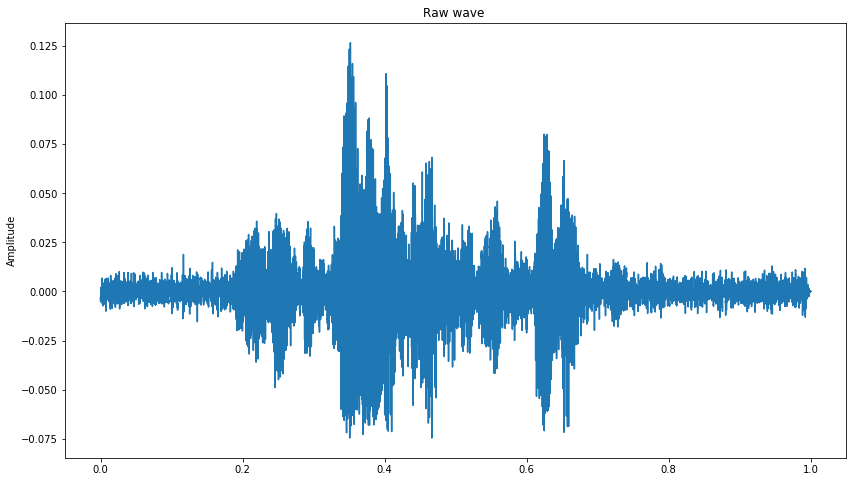

In [104]:
X, sample_rate = librosa.load(data2_df.path[216], res_type='kaiser_fast',duration=4,sr=22050*2,offset=0.5)
plot_time_series(X)
ipd.Audio(X, rate=sample_rate)

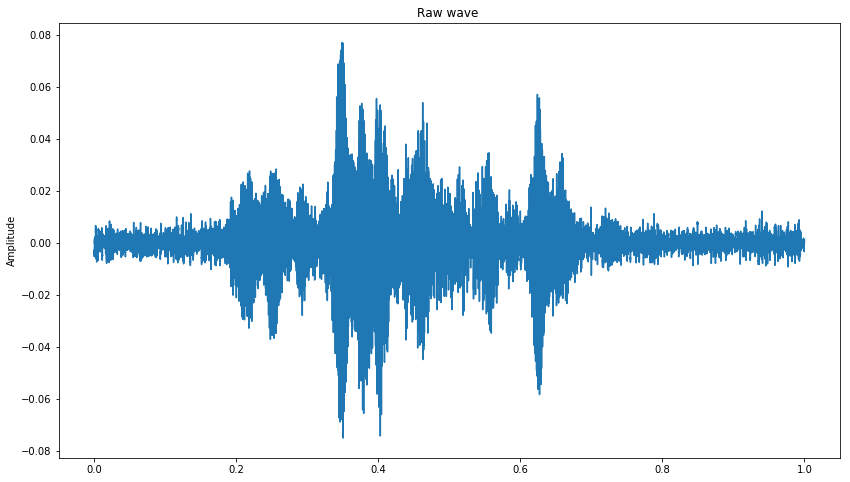

In [105]:
x = pitch(X, sample_rate)
plot_time_series(x)
ipd.Audio(x, rate=sample_rate)

In [106]:
# Augmentation Method 1

syn_data1 = pd.DataFrame(columns=['feature', 'label'])
for i in tqdm(range(len(data2_df))):
    X, sample_rate = librosa.load(data2_df.path[i], res_type='kaiser_fast',duration=input_duration,sr=22050*2,offset=0.5)
    if data2_df.label[i]:
#     if data2_df.label[i] == "male_positive":
        X = noise(X)
        sample_rate = np.array(sample_rate)
        mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13), axis=0)
        feature = mfccs
        a = random.uniform(0, 1)
        syn_data1.loc[i] = [feature, data2_df.label[i]]

100%|██████████████████████████████████████| 3917/3917 [03:23<00:00, 19.23it/s]


In [107]:
# Augmentation Method 2

syn_data2 = pd.DataFrame(columns=['feature', 'label'])
for i in tqdm(range(len(data2_df))):
    X, sample_rate = librosa.load(data2_df.path[i], res_type='kaiser_fast',duration=input_duration,sr=22050*2,offset=0.5)
    if data2_df.label[i]:
#     if data2_df.label[i] == "male_positive":
        X = pitch(X, sample_rate)
        sample_rate = np.array(sample_rate)
        mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13), axis=0)
        feature = mfccs
        a = random.uniform(0, 1)
        syn_data2.loc[i] = [feature, data2_df.label[i]]

100%|██████████████████████████████████████| 3917/3917 [16:02<00:00,  3.78it/s]


In [108]:
len(syn_data1), len(syn_data2)

(3917, 3917)

In [109]:
syn_data1 = syn_data1.reset_index(drop=True)
syn_data2 = syn_data2.reset_index(drop=True)

In [110]:
df4 = pd.DataFrame(syn_data1['feature'].values.tolist())
labels4 = syn_data1.label
syndf1 = pd.concat([df4,labels4], axis=1)
syndf1 = syndf1.rename(index=str, columns={"0": "label"})
syndf1 = syndf1.fillna(0)
len(syndf1)

3917

In [111]:
syndf1.head()

,0,1,2,3,4,5,6,7,8,9,...,250,251,252,253,254,255,256,257,258,label
0,-1.719916,-3.413778,-10.711081,-12.721305,-13.516084,-13.712435,-13.312016,-14.379148,-12.823146,-12.238061,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,male_negative
1,-21.548296,-21.408009,-20.099773,-18.666431,-19.779995,-17.211224,-13.588420,-10.390930,-10.789504,-10.928278,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,male_negative
2,-19.849081,-20.148703,-18.254208,-21.114317,-22.615755,-21.879091,-18.929642,-13.062525,-7.983065,-7.080091,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,male_negative
3,-15.762380,-13.906592,-15.057878,-14.732618,-14.009222,-14.588289,-15.331321,-13.987341,-15.255881,-16.367653,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,male_positive
4,-8.201688,-10.235809,-18.365969,-19.158123,-18.006392,-19.452900,-21.170542,-20.091728,-17.535589,-16.572954,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,male_positive


In [112]:
df4 = pd.DataFrame(syn_data2['feature'].values.tolist())
labels4 = syn_data2.label
syndf2 = pd.concat([df4,labels4], axis=1)
syndf2 = syndf2.rename(index=str, columns={"0": "label"})
syndf2 = syndf2.fillna(0)
len(syndf2)

3917

In [113]:
syndf2.head()

,0,1,2,3,4,5,6,7,8,9,...,250,251,252,253,254,255,256,257,258,label
0,-2.437680,-5.895379,-16.158707,-17.508993,-20.530642,-21.816124,-20.262852,-19.192341,-20.306898,-20.179003,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,male_negative
1,-25.223795,-24.593067,-25.057159,-24.581472,-22.294973,-21.156433,-18.746906,-16.437084,-14.373379,-14.553254,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,male_negative
2,-22.782888,-23.358183,-23.018940,-24.821482,-25.828825,-25.587273,-20.277943,-16.027861,-13.159254,-11.274073,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,male_negative
3,-17.491022,-18.512928,-22.563570,-22.177380,-20.261684,-20.553547,-23.058153,-21.507191,-21.904305,-23.017330,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,male_positive
4,-11.220060,-13.811066,-22.220591,-21.831520,-21.745014,-23.500278,-25.164436,-24.016171,-22.524290,-21.902254,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,male_positive


In [114]:
# Combining the Augmented data with original
combined_df = pd.concat([rnewdf, syndf1, syndf2], ignore_index=True)
combined_df = combined_df.fillna(0)
combined_df.head()

,0,1,2,3,4,5,6,7,8,9,...,250,251,252,253,254,255,256,257,258,label
0,-2.400094,-4.328929,-12.644746,-14.018385,-14.692176,-14.619103,-14.560838,-15.769640,-14.230788,-13.470110,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,male_negative
1,-22.564024,-22.701225,-21.290754,-19.648067,-20.801517,-18.112139,-14.534160,-11.307372,-11.569108,-11.626319,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,male_negative
2,-20.928806,-21.371073,-19.404369,-22.236254,-23.954933,-22.830309,-19.566271,-13.494964,-8.322289,-7.453456,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,male_negative
3,-16.398293,-14.678077,-15.696125,-15.376719,-14.786560,-15.542950,-15.959664,-14.740685,-16.201469,-17.001522,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,male_positive
4,-9.551920,-11.677659,-18.698666,-19.993986,-19.381371,-20.804880,-22.132046,-21.424152,-18.349874,-17.233837,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,male_positive


In [116]:
from sklearn.model_selection import StratifiedShuffleSplit

In [117]:
#  Stratified Shuffle Split

X = combined_df.drop(['label'], axis=1)
y = combined_df.label
xxx = StratifiedShuffleSplit(1, test_size=0.2, random_state=12)
for train_index, test_index in xxx.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

In [118]:
y_train.value_counts()

male_negative    6422
male_positive    2978
Name: label, dtype: int64

In [119]:
y_test.value_counts()

male_negative    1606
male_positive     745
Name: label, dtype: int64

In [120]:
X_train.isna().sum().sum()

0

In [121]:
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)
lb = LabelEncoder()
y_train = np_utils.to_categorical(lb.fit_transform(y_train))
y_test = np_utils.to_categorical(lb.fit_transform(y_test))

In [122]:
y_train

array([[1., 0.],
       [1., 0.],
       [0., 1.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32)

In [123]:
X_train.shape

(9400, 259)

# Changing dimension for CNN model

In [124]:
x_traincnn = np.expand_dims(X_train, axis=2)
x_testcnn = np.expand_dims(X_test, axis=2)

In [125]:
# Set up Keras util functions

from keras import backend as K

def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision


def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall


def fscore(y_true, y_pred):
    if K.sum(K.round(K.clip(y_true, 0, 1))) == 0:
        return 0

    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    f_score = 2 * (p * r) / (p + r + K.epsilon())
    return f_score

def get_lr_metric(optimizer):
    def lr(y_true, y_pred):
        return optimizer.lr
    return lr

In [140]:
# New model
model = Sequential()
model.add(Conv1D(256, 8, padding='same',input_shape=(X_train.shape[1],1)))
model.add(Activation('relu'))
model.add(Conv1D(256, 8, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(128, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(128, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(128, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(128, 8, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(64, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(64, 8, padding='same'))
model.add(Activation('relu'))
model.add(Flatten())
# Edit according to target class no.
model.add(Dense(2))
model.add(Activation('softmax'))
opt = keras.optimizers.adam(lr=0.0001)

In [141]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_41 (Conv1D)           (None, 259, 256)          2304      
_________________________________________________________________
activation_46 (Activation)   (None, 259, 256)          0         
_________________________________________________________________
conv1d_42 (Conv1D)           (None, 259, 256)          524544    
_________________________________________________________________
batch_normalization_11 (Batc (None, 259, 256)          1024      
_________________________________________________________________
activation_47 (Activation)   (None, 259, 256)          0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 259, 256)          0         
_________________________________________________________________
max_pooling1d_11 (MaxPooling (None, 32, 256)           0         
__________

In [142]:
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy', fscore])

In [143]:
# Model Training

lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=20, min_lr=0.000001)
early_callback = keras.callbacks.EarlyStopping(patience=3, monitor='val_loss')
# Please change the model name accordingly.
mcp_save = ModelCheckpoint('../models/aug_noiseNshift_2class2_np.h5', save_best_only=True, monitor='val_loss', mode='min')
cnnhistory=model.fit(x_traincnn, y_train, batch_size=256, epochs=700,
                     validation_data=(x_testcnn, y_test), callbacks=[mcp_save, lr_reduce])

Train on 9400 samples, validate on 2351 samples
Epoch 1/700
9400/9400 [==============================] - ETA: 2:19 - loss: 1.0148 - acc: 0.2812 - fscore: 0.28 - ETA: 1:33 - loss: 0.8578 - acc: 0.4434 - fscore: 0.44 - ETA: 1:16 - loss: 0.7899 - acc: 0.5260 - fscore: 0.52 - ETA: 1:08 - loss: 0.7436 - acc: 0.5693 - fscore: 0.56 - ETA: 1:01 - loss: 0.7223 - acc: 0.5875 - fscore: 0.58 - ETA: 57s - loss: 0.7026 - acc: 0.5983 - fscore: 0.5983 - ETA: 53s - loss: 0.6902 - acc: 0.6027 - fscore: 0.602 - ETA: 50s - loss: 0.6819 - acc: 0.6064 - fscore: 0.606 - ETA: 47s - loss: 0.6702 - acc: 0.6133 - fscore: 0.613 - ETA: 45s - loss: 0.6698 - acc: 0.6172 - fscore: 0.617 - ETA: 43s - loss: 0.6672 - acc: 0.6225 - fscore: 0.622 - ETA: 41s - loss: 0.6600 - acc: 0.6292 - fscore: 0.629 - ETA: 39s - loss: 0.6592 - acc: 0.6304 - fscore: 0.630 - ETA: 37s - loss: 0.6543 - acc: 0.6348 - fscore: 0.634 - ETA: 35s - loss: 0.6527 - acc: 0.6367 - fscore: 0.636 - ETA: 33s - loss: 0.6494 - acc: 0.6399 - fscore: 0.639 

9400/9400 [==============================] - ETA: 55s - loss: 0.5884 - acc: 0.6797 - fscore: 0.679 - ETA: 54s - loss: 0.5820 - acc: 0.6738 - fscore: 0.673 - ETA: 53s - loss: 0.5861 - acc: 0.6784 - fscore: 0.678 - ETA: 52s - loss: 0.5805 - acc: 0.6846 - fscore: 0.684 - ETA: 50s - loss: 0.5855 - acc: 0.6805 - fscore: 0.680 - ETA: 49s - loss: 0.5804 - acc: 0.6875 - fscore: 0.687 - ETA: 47s - loss: 0.5820 - acc: 0.6853 - fscore: 0.685 - ETA: 46s - loss: 0.5850 - acc: 0.6841 - fscore: 0.684 - ETA: 44s - loss: 0.5837 - acc: 0.6871 - fscore: 0.687 - ETA: 43s - loss: 0.5832 - acc: 0.6879 - fscore: 0.687 - ETA: 41s - loss: 0.5859 - acc: 0.6850 - fscore: 0.685 - ETA: 39s - loss: 0.5863 - acc: 0.6868 - fscore: 0.686 - ETA: 38s - loss: 0.5872 - acc: 0.6848 - fscore: 0.684 - ETA: 36s - loss: 0.5890 - acc: 0.6853 - fscore: 0.685 - ETA: 34s - loss: 0.5904 - acc: 0.6820 - fscore: 0.682 - ETA: 33s - loss: 0.5875 - acc: 0.6858 - fscore: 0.685 - ETA: 31s - loss: 0.5878 - acc: 0.6861 - fscore: 0.686 - ETA

9400/9400 [==============================] - ETA: 57s - loss: 0.5500 - acc: 0.7070 - fscore: 0.707 - ETA: 56s - loss: 0.5557 - acc: 0.7109 - fscore: 0.710 - ETA: 54s - loss: 0.5607 - acc: 0.6992 - fscore: 0.699 - ETA: 53s - loss: 0.5579 - acc: 0.7021 - fscore: 0.702 - ETA: 51s - loss: 0.5514 - acc: 0.7141 - fscore: 0.714 - ETA: 49s - loss: 0.5495 - acc: 0.7161 - fscore: 0.716 - ETA: 48s - loss: 0.5639 - acc: 0.7048 - fscore: 0.704 - ETA: 46s - loss: 0.5701 - acc: 0.7012 - fscore: 0.701 - ETA: 44s - loss: 0.5685 - acc: 0.7040 - fscore: 0.704 - ETA: 43s - loss: 0.5747 - acc: 0.7008 - fscore: 0.700 - ETA: 41s - loss: 0.5738 - acc: 0.7024 - fscore: 0.702 - ETA: 40s - loss: 0.5698 - acc: 0.7051 - fscore: 0.705 - ETA: 38s - loss: 0.5702 - acc: 0.7067 - fscore: 0.706 - ETA: 36s - loss: 0.5727 - acc: 0.7042 - fscore: 0.704 - ETA: 35s - loss: 0.5716 - acc: 0.7034 - fscore: 0.703 - ETA: 33s - loss: 0.5695 - acc: 0.7051 - fscore: 0.705 - ETA: 31s - loss: 0.5746 - acc: 0.7004 - fscore: 0.700 - ETA

9400/9400 [==============================] - ETA: 56s - loss: 0.5657 - acc: 0.7031 - fscore: 0.703 - ETA: 55s - loss: 0.5571 - acc: 0.7129 - fscore: 0.712 - ETA: 53s - loss: 0.5737 - acc: 0.6953 - fscore: 0.695 - ETA: 52s - loss: 0.5789 - acc: 0.6992 - fscore: 0.699 - ETA: 50s - loss: 0.5782 - acc: 0.6992 - fscore: 0.699 - ETA: 49s - loss: 0.5687 - acc: 0.7025 - fscore: 0.702 - ETA: 47s - loss: 0.5674 - acc: 0.7037 - fscore: 0.703 - ETA: 46s - loss: 0.5665 - acc: 0.7056 - fscore: 0.705 - ETA: 44s - loss: 0.5638 - acc: 0.7075 - fscore: 0.707 - ETA: 42s - loss: 0.5614 - acc: 0.7098 - fscore: 0.709 - ETA: 41s - loss: 0.5678 - acc: 0.7031 - fscore: 0.703 - ETA: 39s - loss: 0.5704 - acc: 0.7012 - fscore: 0.701 - ETA: 37s - loss: 0.5662 - acc: 0.7037 - fscore: 0.703 - ETA: 36s - loss: 0.5654 - acc: 0.7045 - fscore: 0.704 - ETA: 34s - loss: 0.5636 - acc: 0.7052 - fscore: 0.705 - ETA: 33s - loss: 0.5619 - acc: 0.7061 - fscore: 0.706 - ETA: 31s - loss: 0.5603 - acc: 0.7075 - fscore: 0.707 - ETA

9400/9400 [==============================] - ETA: 56s - loss: 0.5545 - acc: 0.7031 - fscore: 0.703 - ETA: 55s - loss: 0.5444 - acc: 0.7246 - fscore: 0.724 - ETA: 54s - loss: 0.5606 - acc: 0.7031 - fscore: 0.703 - ETA: 52s - loss: 0.5559 - acc: 0.7080 - fscore: 0.708 - ETA: 50s - loss: 0.5536 - acc: 0.7070 - fscore: 0.707 - ETA: 49s - loss: 0.5573 - acc: 0.7038 - fscore: 0.703 - ETA: 47s - loss: 0.5540 - acc: 0.7098 - fscore: 0.709 - ETA: 46s - loss: 0.5485 - acc: 0.7168 - fscore: 0.716 - ETA: 44s - loss: 0.5470 - acc: 0.7227 - fscore: 0.722 - ETA: 43s - loss: 0.5466 - acc: 0.7246 - fscore: 0.724 - ETA: 41s - loss: 0.5467 - acc: 0.7251 - fscore: 0.725 - ETA: 40s - loss: 0.5437 - acc: 0.7256 - fscore: 0.725 - ETA: 38s - loss: 0.5408 - acc: 0.7275 - fscore: 0.727 - ETA: 36s - loss: 0.5473 - acc: 0.7235 - fscore: 0.723 - ETA: 35s - loss: 0.5471 - acc: 0.7250 - fscore: 0.725 - ETA: 33s - loss: 0.5490 - acc: 0.7234 - fscore: 0.723 - ETA: 31s - loss: 0.5507 - acc: 0.7233 - fscore: 0.723 - ETA

9400/9400 [==============================] - ETA: 58s - loss: 0.5674 - acc: 0.6875 - fscore: 0.687 - ETA: 56s - loss: 0.5365 - acc: 0.7227 - fscore: 0.722 - ETA: 54s - loss: 0.5342 - acc: 0.7240 - fscore: 0.724 - ETA: 53s - loss: 0.5316 - acc: 0.7285 - fscore: 0.728 - ETA: 51s - loss: 0.5217 - acc: 0.7391 - fscore: 0.739 - ETA: 49s - loss: 0.5150 - acc: 0.7493 - fscore: 0.749 - ETA: 48s - loss: 0.5206 - acc: 0.7405 - fscore: 0.740 - ETA: 46s - loss: 0.5189 - acc: 0.7402 - fscore: 0.740 - ETA: 44s - loss: 0.5186 - acc: 0.7426 - fscore: 0.742 - ETA: 43s - loss: 0.5240 - acc: 0.7426 - fscore: 0.742 - ETA: 41s - loss: 0.5216 - acc: 0.7440 - fscore: 0.744 - ETA: 39s - loss: 0.5210 - acc: 0.7441 - fscore: 0.744 - ETA: 38s - loss: 0.5216 - acc: 0.7425 - fscore: 0.742 - ETA: 36s - loss: 0.5212 - acc: 0.7425 - fscore: 0.742 - ETA: 35s - loss: 0.5179 - acc: 0.7440 - fscore: 0.744 - ETA: 33s - loss: 0.5191 - acc: 0.7415 - fscore: 0.741 - ETA: 31s - loss: 0.5180 - acc: 0.7422 - fscore: 0.742 - ETA

9400/9400 [==============================] - ETA: 59s - loss: 0.4861 - acc: 0.7734 - fscore: 0.773 - ETA: 57s - loss: 0.4576 - acc: 0.7910 - fscore: 0.791 - ETA: 56s - loss: 0.4663 - acc: 0.7786 - fscore: 0.778 - ETA: 54s - loss: 0.4631 - acc: 0.7881 - fscore: 0.788 - ETA: 52s - loss: 0.4770 - acc: 0.7750 - fscore: 0.775 - ETA: 50s - loss: 0.4798 - acc: 0.7702 - fscore: 0.770 - ETA: 48s - loss: 0.4772 - acc: 0.7740 - fscore: 0.774 - ETA: 47s - loss: 0.4750 - acc: 0.7725 - fscore: 0.772 - ETA: 45s - loss: 0.4745 - acc: 0.7726 - fscore: 0.772 - ETA: 43s - loss: 0.4728 - acc: 0.7738 - fscore: 0.773 - ETA: 41s - loss: 0.4730 - acc: 0.7738 - fscore: 0.773 - ETA: 40s - loss: 0.4711 - acc: 0.7747 - fscore: 0.774 - ETA: 38s - loss: 0.4756 - acc: 0.7725 - fscore: 0.772 - ETA: 36s - loss: 0.4782 - acc: 0.7698 - fscore: 0.769 - ETA: 35s - loss: 0.4788 - acc: 0.7701 - fscore: 0.770 - ETA: 33s - loss: 0.4802 - acc: 0.7688 - fscore: 0.768 - ETA: 32s - loss: 0.4808 - acc: 0.7691 - fscore: 0.769 - ETA

9400/9400 [==============================] - ETA: 58s - loss: 0.4437 - acc: 0.7891 - fscore: 0.789 - ETA: 56s - loss: 0.4326 - acc: 0.8145 - fscore: 0.814 - ETA: 54s - loss: 0.4328 - acc: 0.8021 - fscore: 0.802 - ETA: 52s - loss: 0.4297 - acc: 0.7998 - fscore: 0.799 - ETA: 51s - loss: 0.4248 - acc: 0.8063 - fscore: 0.806 - ETA: 49s - loss: 0.4231 - acc: 0.8060 - fscore: 0.806 - ETA: 47s - loss: 0.4214 - acc: 0.8058 - fscore: 0.805 - ETA: 46s - loss: 0.4261 - acc: 0.7998 - fscore: 0.799 - ETA: 44s - loss: 0.4283 - acc: 0.7982 - fscore: 0.798 - ETA: 43s - loss: 0.4250 - acc: 0.8004 - fscore: 0.800 - ETA: 41s - loss: 0.4262 - acc: 0.8015 - fscore: 0.801 - ETA: 39s - loss: 0.4267 - acc: 0.8008 - fscore: 0.800 - ETA: 38s - loss: 0.4257 - acc: 0.7996 - fscore: 0.799 - ETA: 36s - loss: 0.4255 - acc: 0.8008 - fscore: 0.800 - ETA: 35s - loss: 0.4285 - acc: 0.8003 - fscore: 0.800 - ETA: 33s - loss: 0.4296 - acc: 0.7991 - fscore: 0.799 - ETA: 31s - loss: 0.4292 - acc: 0.7996 - fscore: 0.799 - ETA

9400/9400 [==============================] - ETA: 58s - loss: 0.3507 - acc: 0.8398 - fscore: 0.839 - ETA: 56s - loss: 0.3571 - acc: 0.8398 - fscore: 0.839 - ETA: 54s - loss: 0.3546 - acc: 0.8451 - fscore: 0.845 - ETA: 53s - loss: 0.3558 - acc: 0.8516 - fscore: 0.851 - ETA: 51s - loss: 0.3558 - acc: 0.8531 - fscore: 0.853 - ETA: 50s - loss: 0.3531 - acc: 0.8535 - fscore: 0.853 - ETA: 48s - loss: 0.3545 - acc: 0.8493 - fscore: 0.849 - ETA: 47s - loss: 0.3606 - acc: 0.8433 - fscore: 0.843 - ETA: 45s - loss: 0.3611 - acc: 0.8459 - fscore: 0.845 - ETA: 44s - loss: 0.3566 - acc: 0.8480 - fscore: 0.848 - ETA: 42s - loss: 0.3587 - acc: 0.8438 - fscore: 0.843 - ETA: 40s - loss: 0.3578 - acc: 0.8438 - fscore: 0.843 - ETA: 38s - loss: 0.3588 - acc: 0.8431 - fscore: 0.843 - ETA: 37s - loss: 0.3582 - acc: 0.8451 - fscore: 0.845 - ETA: 35s - loss: 0.3604 - acc: 0.8432 - fscore: 0.843 - ETA: 33s - loss: 0.3615 - acc: 0.8433 - fscore: 0.843 - ETA: 32s - loss: 0.3638 - acc: 0.8419 - fscore: 0.841 - ETA

9400/9400 [==============================] - ETA: 58s - loss: 0.2943 - acc: 0.8672 - fscore: 0.867 - ETA: 57s - loss: 0.2686 - acc: 0.8789 - fscore: 0.878 - ETA: 55s - loss: 0.2812 - acc: 0.8711 - fscore: 0.871 - ETA: 54s - loss: 0.3037 - acc: 0.8623 - fscore: 0.862 - ETA: 52s - loss: 0.2971 - acc: 0.8641 - fscore: 0.864 - ETA: 50s - loss: 0.2983 - acc: 0.8652 - fscore: 0.865 - ETA: 49s - loss: 0.3036 - acc: 0.8633 - fscore: 0.863 - ETA: 47s - loss: 0.3063 - acc: 0.8623 - fscore: 0.862 - ETA: 45s - loss: 0.3006 - acc: 0.8668 - fscore: 0.866 - ETA: 44s - loss: 0.3041 - acc: 0.8645 - fscore: 0.864 - ETA: 42s - loss: 0.3081 - acc: 0.8647 - fscore: 0.864 - ETA: 40s - loss: 0.3120 - acc: 0.8613 - fscore: 0.861 - ETA: 39s - loss: 0.3101 - acc: 0.8639 - fscore: 0.863 - ETA: 37s - loss: 0.3071 - acc: 0.8658 - fscore: 0.865 - ETA: 35s - loss: 0.3060 - acc: 0.8674 - fscore: 0.867 - ETA: 34s - loss: 0.3033 - acc: 0.8696 - fscore: 0.869 - ETA: 32s - loss: 0.3017 - acc: 0.8704 - fscore: 0.870 - ETA

9400/9400 [==============================] - ETA: 57s - loss: 0.2204 - acc: 0.9023 - fscore: 0.902 - ETA: 55s - loss: 0.2203 - acc: 0.9043 - fscore: 0.904 - ETA: 54s - loss: 0.2251 - acc: 0.9089 - fscore: 0.908 - ETA: 52s - loss: 0.2297 - acc: 0.9014 - fscore: 0.901 - ETA: 51s - loss: 0.2389 - acc: 0.9023 - fscore: 0.902 - ETA: 49s - loss: 0.2387 - acc: 0.9017 - fscore: 0.901 - ETA: 48s - loss: 0.2445 - acc: 0.9001 - fscore: 0.900 - ETA: 46s - loss: 0.2432 - acc: 0.9014 - fscore: 0.901 - ETA: 44s - loss: 0.2364 - acc: 0.9045 - fscore: 0.904 - ETA: 43s - loss: 0.2351 - acc: 0.9043 - fscore: 0.904 - ETA: 41s - loss: 0.2344 - acc: 0.9038 - fscore: 0.903 - ETA: 39s - loss: 0.2370 - acc: 0.9049 - fscore: 0.904 - ETA: 38s - loss: 0.2379 - acc: 0.9047 - fscore: 0.904 - ETA: 36s - loss: 0.2396 - acc: 0.9032 - fscore: 0.903 - ETA: 35s - loss: 0.2455 - acc: 0.9003 - fscore: 0.900 - ETA: 33s - loss: 0.2446 - acc: 0.9011 - fscore: 0.901 - ETA: 31s - loss: 0.2474 - acc: 0.8996 - fscore: 0.899 - ETA

9400/9400 [==============================] - ETA: 57s - loss: 0.1664 - acc: 0.9336 - fscore: 0.933 - ETA: 57s - loss: 0.1758 - acc: 0.9316 - fscore: 0.931 - ETA: 56s - loss: 0.1847 - acc: 0.9245 - fscore: 0.924 - ETA: 54s - loss: 0.1864 - acc: 0.9229 - fscore: 0.922 - ETA: 52s - loss: 0.1868 - acc: 0.9227 - fscore: 0.922 - ETA: 50s - loss: 0.1839 - acc: 0.9264 - fscore: 0.926 - ETA: 48s - loss: 0.1832 - acc: 0.9241 - fscore: 0.924 - ETA: 47s - loss: 0.1866 - acc: 0.9214 - fscore: 0.921 - ETA: 45s - loss: 0.1885 - acc: 0.9201 - fscore: 0.920 - ETA: 44s - loss: 0.1877 - acc: 0.9215 - fscore: 0.921 - ETA: 42s - loss: 0.1880 - acc: 0.9212 - fscore: 0.921 - ETA: 40s - loss: 0.1861 - acc: 0.9229 - fscore: 0.922 - ETA: 39s - loss: 0.1854 - acc: 0.9231 - fscore: 0.923 - ETA: 37s - loss: 0.1852 - acc: 0.9233 - fscore: 0.923 - ETA: 35s - loss: 0.1854 - acc: 0.9237 - fscore: 0.923 - ETA: 34s - loss: 0.1870 - acc: 0.9231 - fscore: 0.923 - ETA: 32s - loss: 0.1859 - acc: 0.9244 - fscore: 0.924 - ETA

9400/9400 [==============================] - ETA: 58s - loss: 0.1391 - acc: 0.9531 - fscore: 0.953 - ETA: 56s - loss: 0.1238 - acc: 0.9570 - fscore: 0.957 - ETA: 54s - loss: 0.1190 - acc: 0.9544 - fscore: 0.954 - ETA: 53s - loss: 0.1231 - acc: 0.9531 - fscore: 0.953 - ETA: 51s - loss: 0.1262 - acc: 0.9539 - fscore: 0.953 - ETA: 49s - loss: 0.1220 - acc: 0.9557 - fscore: 0.955 - ETA: 48s - loss: 0.1225 - acc: 0.9570 - fscore: 0.957 - ETA: 46s - loss: 0.1187 - acc: 0.9580 - fscore: 0.958 - ETA: 44s - loss: 0.1183 - acc: 0.9596 - fscore: 0.959 - ETA: 43s - loss: 0.1169 - acc: 0.9586 - fscore: 0.958 - ETA: 41s - loss: 0.1182 - acc: 0.9581 - fscore: 0.958 - ETA: 40s - loss: 0.1170 - acc: 0.9587 - fscore: 0.958 - ETA: 38s - loss: 0.1198 - acc: 0.9573 - fscore: 0.957 - ETA: 37s - loss: 0.1207 - acc: 0.9559 - fscore: 0.955 - ETA: 35s - loss: 0.1205 - acc: 0.9552 - fscore: 0.955 - ETA: 33s - loss: 0.1223 - acc: 0.9546 - fscore: 0.954 - ETA: 32s - loss: 0.1268 - acc: 0.9522 - fscore: 0.952 - ETA

9400/9400 [==============================] - ETA: 58s - loss: 0.1089 - acc: 0.9727 - fscore: 0.972 - ETA: 57s - loss: 0.1274 - acc: 0.9512 - fscore: 0.951 - ETA: 56s - loss: 0.1308 - acc: 0.9531 - fscore: 0.953 - ETA: 54s - loss: 0.1222 - acc: 0.9541 - fscore: 0.954 - ETA: 53s - loss: 0.1204 - acc: 0.9555 - fscore: 0.955 - ETA: 51s - loss: 0.1273 - acc: 0.9499 - fscore: 0.949 - ETA: 49s - loss: 0.1276 - acc: 0.9509 - fscore: 0.950 - ETA: 48s - loss: 0.1282 - acc: 0.9512 - fscore: 0.951 - ETA: 46s - loss: 0.1261 - acc: 0.9514 - fscore: 0.951 - ETA: 44s - loss: 0.1233 - acc: 0.9520 - fscore: 0.952 - ETA: 43s - loss: 0.1228 - acc: 0.9524 - fscore: 0.952 - ETA: 41s - loss: 0.1212 - acc: 0.9531 - fscore: 0.953 - ETA: 39s - loss: 0.1206 - acc: 0.9528 - fscore: 0.952 - ETA: 37s - loss: 0.1218 - acc: 0.9520 - fscore: 0.952 - ETA: 36s - loss: 0.1195 - acc: 0.9523 - fscore: 0.952 - ETA: 34s - loss: 0.1213 - acc: 0.9507 - fscore: 0.950 - ETA: 32s - loss: 0.1197 - acc: 0.9511 - fscore: 0.951 - ETA

KeyboardInterrupt: 

In [ ]:
# Plotting the Train Valid Loss Graph

plt.plot(cnnhistory.history['loss'])
plt.plot(cnnhistory.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()